In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 512
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -146.57782247848212
max pF: 2.5253136357059445
max photon: 30.72699609771371
photon time: 0.8013310200741781
smoothness: 0.004047764788710292
global update: 200
reward: -80.28672553876488
max pF: 2.55730284239534
max photon: 39.47179866582155
photon time: 0.7800985984227036
smoothness: 0.002474116490058965
global update: 300
reward: -35.41559025522566
max pF: 2.56096785139144
max photon: 40.76890539377928
photon time: 0.6846559815259479
smoothness: 0.0014276209857026195
global update: 400
reward: -3.1614456578907655
max pF: 2.556641957722416
max photon: 39.88225677609444
photon time: 0.4022511049681634
smoothness: 0.0007486067928196242
global update: 500
reward: 9.084765868457595
max pF: 2.5601122541360084
max photon: 40.28799131512642
photon time: 0.36940442225105247
smoothness: 0.00047809320557700027
global update: 600
reward: 17.19311969345584
max pF: 2.5597882084029653
max photon: 40.41492985188961
photon time: 0.35708132639

In [5]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
actions = metrics["action"]

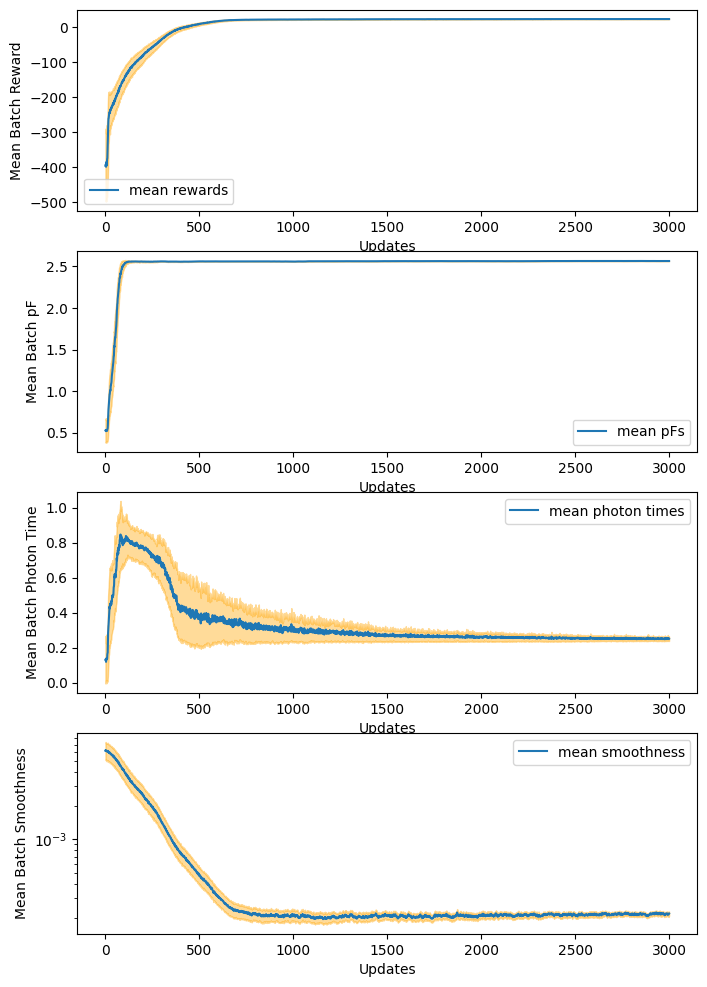

In [15]:
mean_rewards = jnp.mean(rewards, axis=-1)
std_rewards = jnp.std(rewards, axis=-1)

mean_pFs = jnp.mean(max_pFs, axis=-1)
std_pFs = jnp.std(max_pFs, axis=-1)

mean_times = jnp.mean(photon_times, axis=-1)
std_times = jnp.std(photon_times, axis=-1)

mean_smoothnesses = jnp.mean(smoothnesses, axis=-1)
std_smoothnesses = jnp.std(smoothnesses, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards, label='mean rewards')
ax[0].fill_between(jnp.arange(num_updates), mean_rewards - std_rewards, mean_rewards + std_rewards, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs, label='mean pFs')
ax[1].fill_between(jnp.arange(num_updates), mean_pFs - std_pFs, mean_pFs + std_pFs, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times, label='mean photon times')
ax[2].fill_between(jnp.arange(num_updates), mean_times - std_times, mean_times + std_times, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses, label='mean noisiness')
ax[3].fill_between(jnp.arange(num_updates), mean_smoothnesses - std_smoothnesses, mean_smoothnesses + std_smoothnesses, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

### Increasing Fidelity Coefficent

In [9]:
single_train_2 = jit(PPO_make_train(config), static_argnums=(-2, -1))

snr_coeff_2 = 20.0

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff_2,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -115.75162894455502
max pF: 2.559357601663483
max photon: 37.92115780338645
photon time: 0.9038212396059535
smoothness: 0.0038907947208070472
global update: 200
reward: -54.74977204419642
max pF: 2.5590921153508606
max photon: 40.03639719635248
photon time: 0.8400423298726549
smoothness: 0.002464258297640538
global update: 300
reward: -8.62638745254287
max pF: 2.561978149058984
max photon: 40.74025351554155
photon time: 0.7796906413683486
smoothness: 0.0013987468844249562
global update: 400
reward: 16.70134388576068
max pF: 2.5609002825680216
max photon: 39.59030544757843
photon time: 0.7098228083600171
smoothness: 0.0008399743795018916
global update: 500
reward: 29.8578679948021
max pF: 2.5622837953365756
max photon: 40.093491680920124
photon time: 0.6478236742003636
smoothness: 0.0005534505202697007
global update: 600
reward: 40.21838498346297
max pF: 2.5615199729833327
max photon: 39.770108968019485
photon time: 0.41281493960

In [10]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
actions_2 = metrics_2["action"]

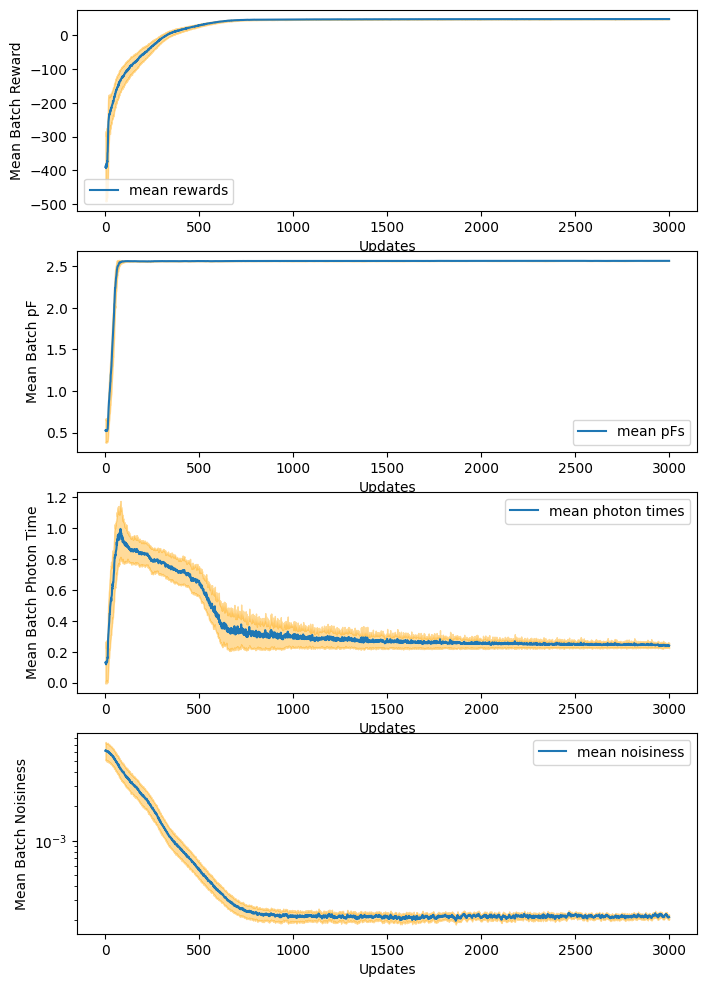

In [16]:
mean_rewards_2 = jnp.mean(rewards_2, axis=-1)
std_rewards_2 = jnp.std(rewards_2, axis=-1)

mean_pFs_2 = jnp.mean(max_pFs_2, axis=-1)
std_pFs_2 = jnp.std(max_pFs_2, axis=-1)

mean_times_2 = jnp.mean(photon_times_2, axis=-1)
std_times_2 = jnp.std(photon_times_2, axis=-1)

mean_smoothnesses_2 = jnp.mean(smoothnesses_2, axis=-1)
std_smoothnesses_2 = jnp.std(smoothnesses_2, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_2, label='mean rewards')
ax[0].fill_between(jnp.arange(num_updates), mean_rewards_2 - std_rewards_2, mean_rewards_2 + std_rewards_2, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_2, label='mean pFs')
ax[1].fill_between(jnp.arange(num_updates), mean_pFs_2 - std_pFs_2, mean_pFs_2 + std_pFs_2, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_2, label='mean photon times')
ax[2].fill_between(jnp.arange(num_updates), mean_times_2 - std_times_2, mean_times_2 + std_times_2, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_2, label='mean noisiness')
ax[3].fill_between(jnp.arange(num_updates), mean_smoothnesses_2 - std_smoothnesses_2, mean_smoothnesses_2 + std_smoothnesses_2, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

## Reducing Batchsize

In [19]:
num_envs_2 = 256

config_2 = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs_2,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs_2 / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [21]:
single_train_low = jit(PPO_make_train(config_2), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_low = single_train_low(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs_2)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -191.77704931975686
max pF: 2.384938116772288
max photon: 24.65880297869444
photon time: 0.7428197447861723
smoothness: 0.005087343660085116
global update: 200
reward: -151.02544544909045
max pF: 2.560616818579245
max photon: 41.13502574712038
photon time: 0.8187370920671759
smoothness: 0.004074422136902968
global update: 300
reward: -116.43323310158956
max pF: 2.5609737962994705
max photon: 40.25551715493202
photon time: 0.8063498028204753
smoothness: 0.003291552399329601
global update: 400
reward: -77.57532008474683
max pF: 2.5628982642204834
max photon: 39.89603418111801
photon time: 0.7655321109183897
smoothness: 0.0024104002959961356
global update: 500
reward: -45.02314035723498
max pF: 2.562996016521817
max photon: 40.41325229406357
photon time: 0.7308153259004999
smoothness: 0.001653353209123773
global update: 600
reward: -25.971473368158975
max pF: 2.5637527180491846
max photon: 40.337393552064896
photon time: 0.67275766

In [22]:
# Extracting Results

metrics_low = single_result_low["metrics"]

rewards_low = metrics_low["reward"]
max_pFs_low = metrics_low["max pF"]
max_photons_low = metrics_low["max photon"]
photon_times_low = metrics_low["photon time"]
smoothnesses_low = metrics_low["smoothness"]
actions_low = metrics_low["action"]

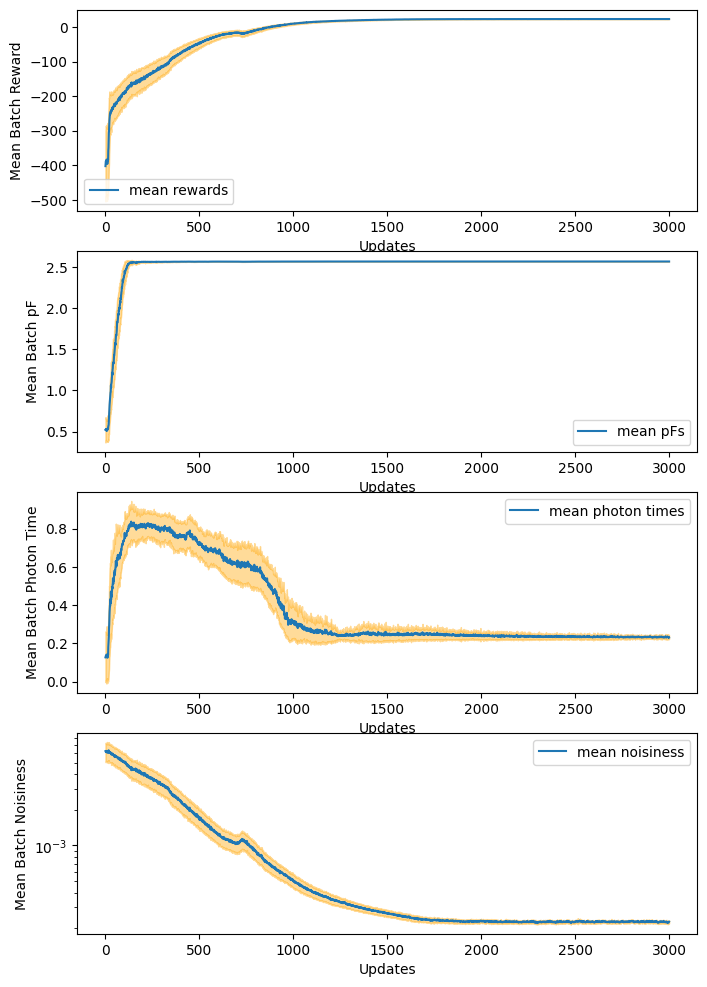

In [23]:
mean_rewards_low = jnp.mean(rewards_low, axis=-1)
std_rewards_low = jnp.std(rewards_low, axis=-1)

mean_pFs_low = jnp.mean(max_pFs_low, axis=-1)
std_pFs_low = jnp.std(max_pFs_low, axis=-1)

mean_times_low = jnp.mean(photon_times_low, axis=-1)
std_times_low = jnp.std(photon_times_low, axis=-1)

mean_smoothnesses_low = jnp.mean(smoothnesses_low, axis=-1)
std_smoothnesses_low = jnp.std(smoothnesses_low, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_low, label='mean rewards')
ax[0].fill_between(jnp.arange(num_updates), mean_rewards_low - std_rewards_low, mean_rewards_low + std_rewards_low, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_low, label='mean pFs')
ax[1].fill_between(jnp.arange(num_updates), mean_pFs_low - std_pFs_low, mean_pFs_low + std_pFs_low, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_low, label='mean photon times')
ax[2].fill_between(jnp.arange(num_updates), mean_times_low - std_times_low, mean_times_low + std_times_low, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_low, label='mean noisiness')
ax[3].fill_between(jnp.arange(num_updates), mean_smoothnesses_low - std_smoothnesses_low, mean_smoothnesses_low + std_smoothnesses_low, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

## Reducing Batchsize Lower to 128

In [41]:
num_envs_3 = 128
num_updates_2 = 4000

config_3 = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs_3,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates_2,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs_3 / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [42]:
single_train_lower = jit(PPO_make_train(config_3), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates_2} Updates")
start = time.time()
single_result_lower = single_train_lower(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs_3)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -223.67859231774784
max pF: 1.727846820950773
max photon: 11.189910188317299
photon time: 0.6431383535510461
smoothness: 0.005712939843897199
global update: 200
reward: -209.7463800579143
max pF: 2.0863787071664657
max photon: 15.50258494913578
photon time: 0.7094610509844398
smoothness: 0.005465278427269963
global update: 300
reward: -199.1698097912254
max pF: 2.3811993208884816
max photon: 21.372295528650284
photon time: 0.7911192015233848
smoothness: 0.005261878829046324
global update: 400
reward: -175.14262920436295
max pF: 2.5367518961928504
max photon: 30.531605646014214
photon time: 0.845921881465047
smoothness: 0.0047167325479135795
global update: 500
reward: -155.4147878025891
max pF: 2.560388802269901
max photon: 38.59366253018379
photon time: 0.8671474304748585
smoothness: 0.004212701911731684
global update: 600
reward: -110.33292480103574
max pF: 2.5569377620926903
max photon: 39.7566477060318
photon time: 0.78364198

## Comparing Actions

In [25]:
# Evaluating Mean Action per Batch

mean_actions = jnp.mean(actions, axis=1)
mean_actions_2 = jnp.mean(actions_2, axis=1)
mean_actions_low = jnp.mean(actions_low, axis=1)

In [27]:
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

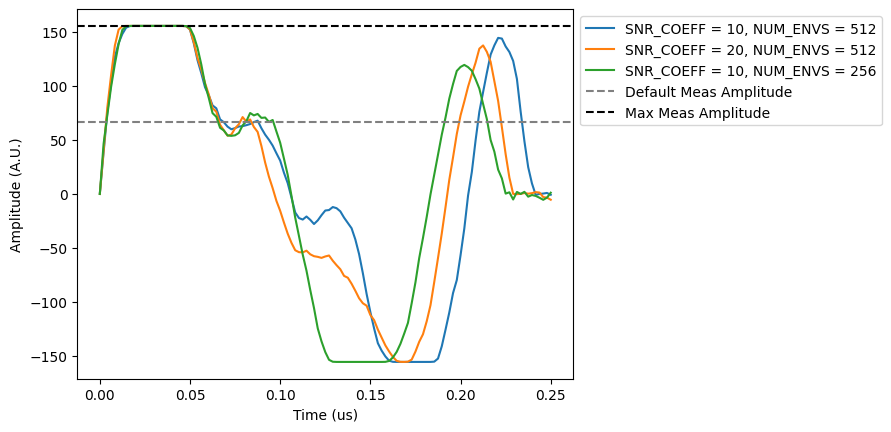

In [32]:
smooth_action = env.prepare_action(mean_actions[-1])
smooth_action_2 = env.prepare_action(mean_actions_2[-1])
smooth_action_low = env.prepare_action(-mean_actions_low[-1])

plt.plot(env.ts_action, smooth_action, label='SNR_COEFF = 10, NUM_ENVS = 512')
plt.plot(env.ts_action, smooth_action_2, label='SNR_COEFF = 20, NUM_ENVS = 512')
plt.plot(env.ts_action, smooth_action_low, label='SNR_COEFF = 10, NUM_ENVS = 256')
plt.axhline(y=env.a0, label='Default Meas Amplitude', linestyle='dashed', color='grey')
plt.axhline(y=env.a0 * env.mu, label='Max Meas Amplitude', linestyle='dashed', color='black')
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.show()

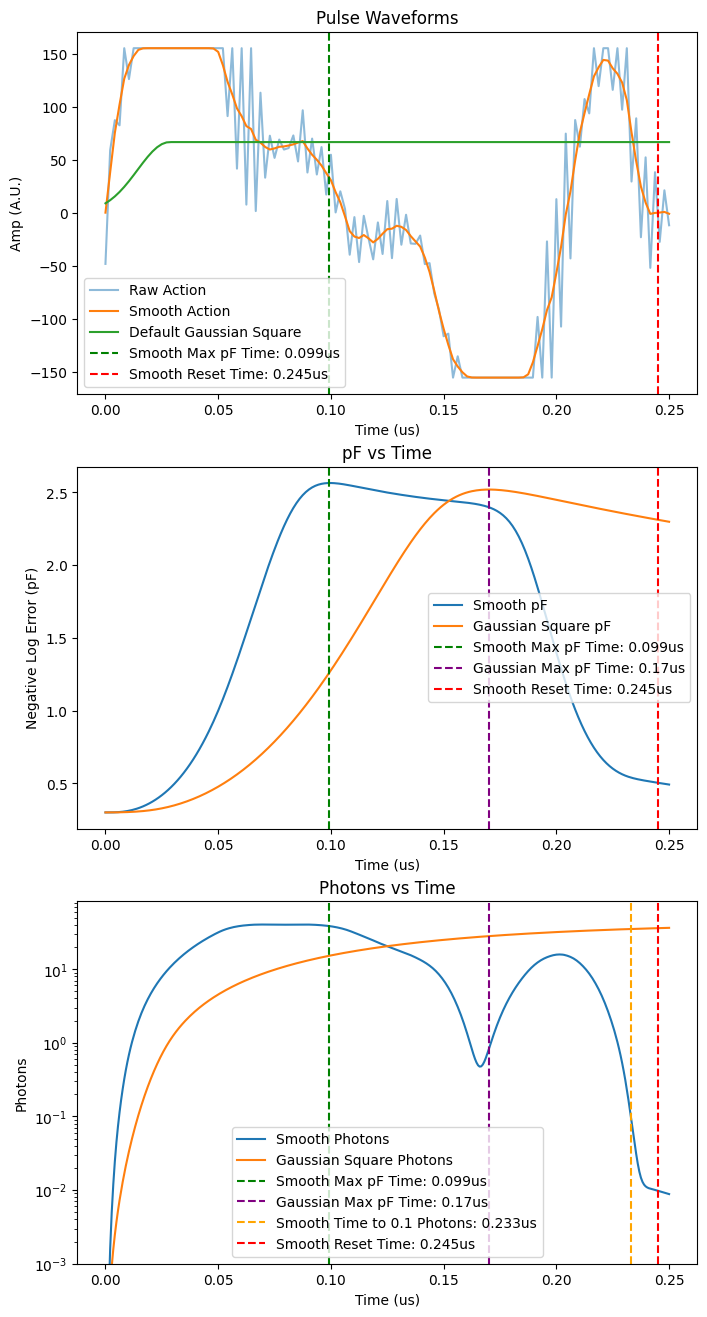

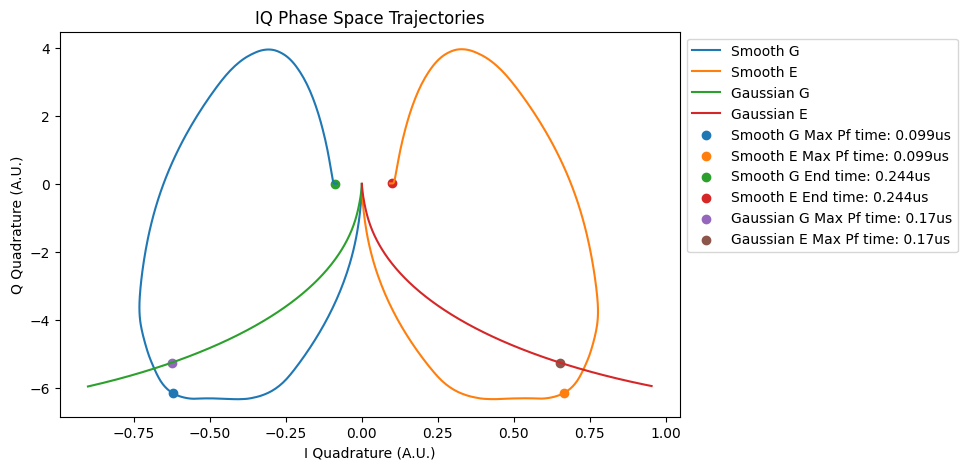

In [38]:
env.rollout_action(mean_actions[-1], photon_log_scale=True)

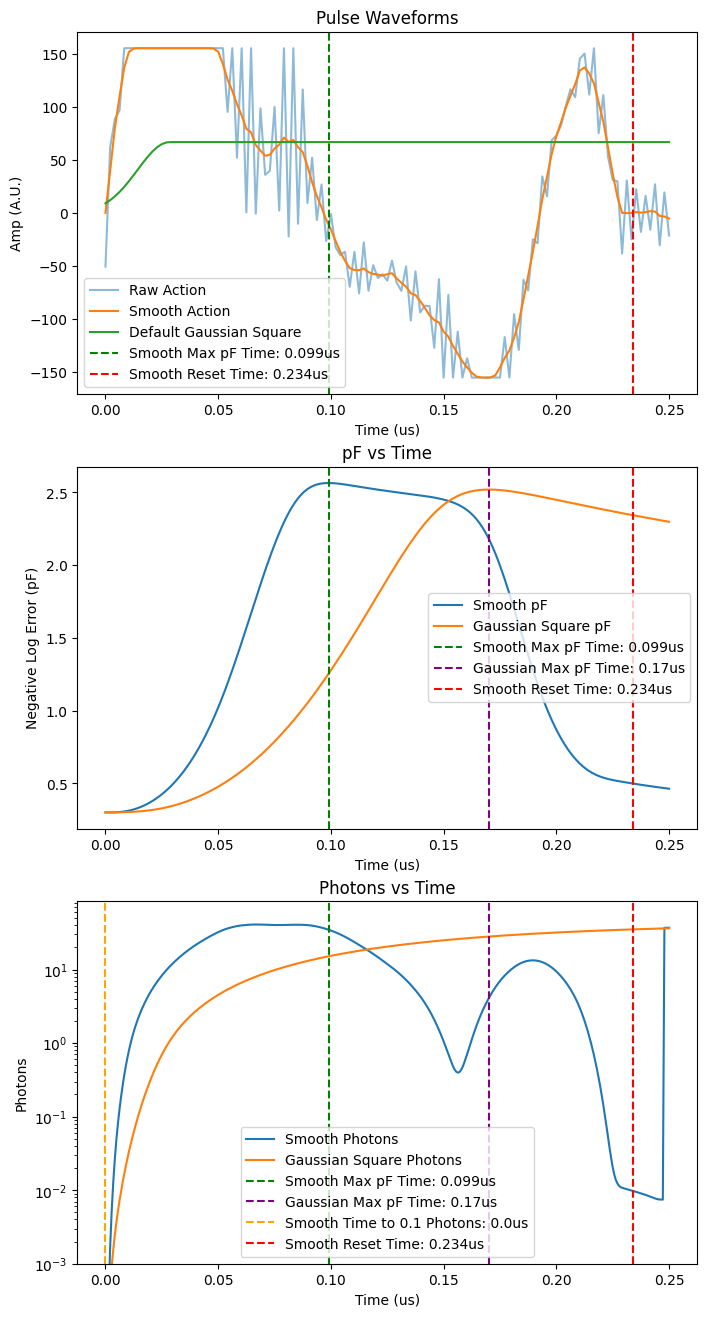

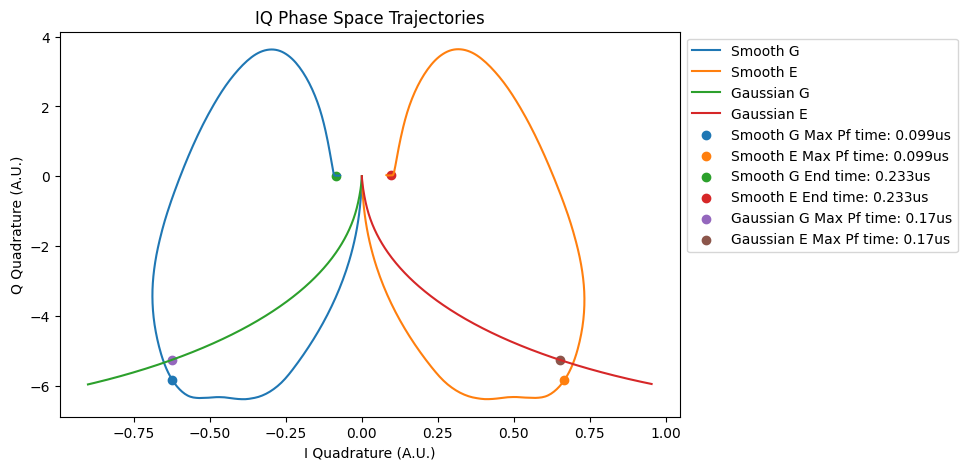

In [37]:
env.rollout_action(mean_actions_2[-1], photon_log_scale=True)

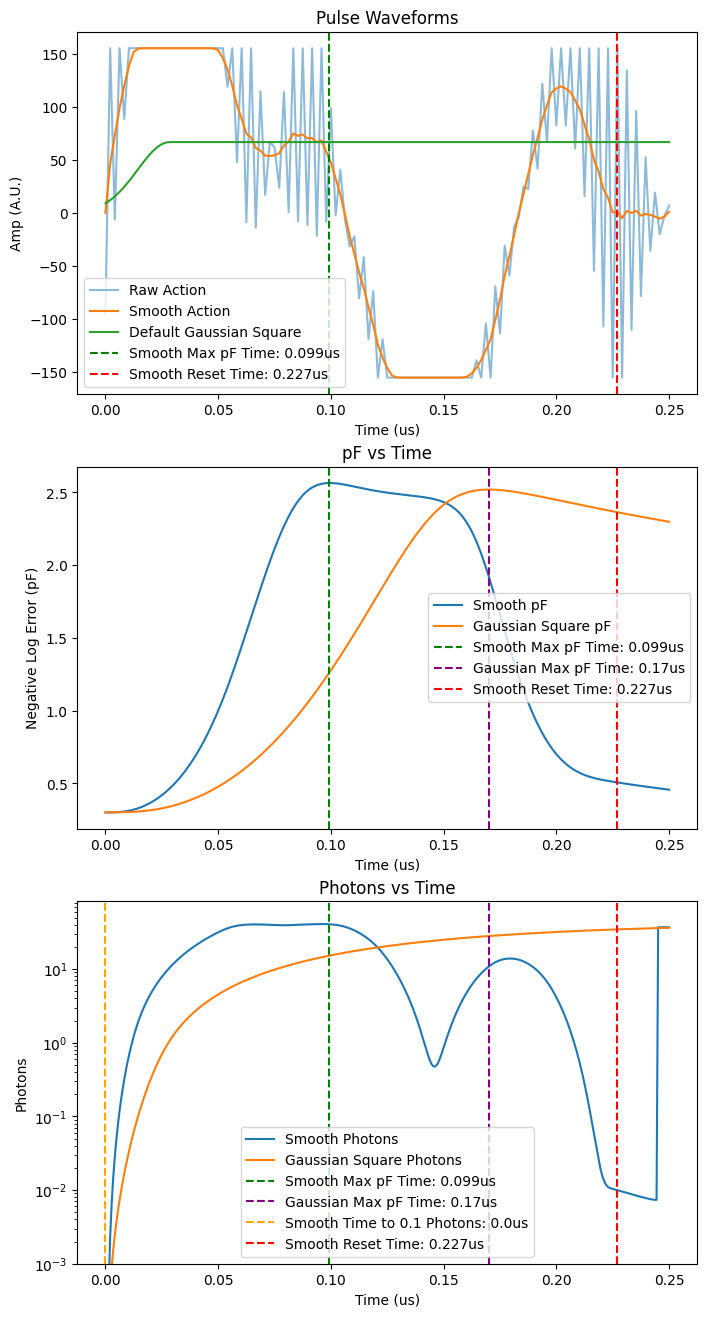

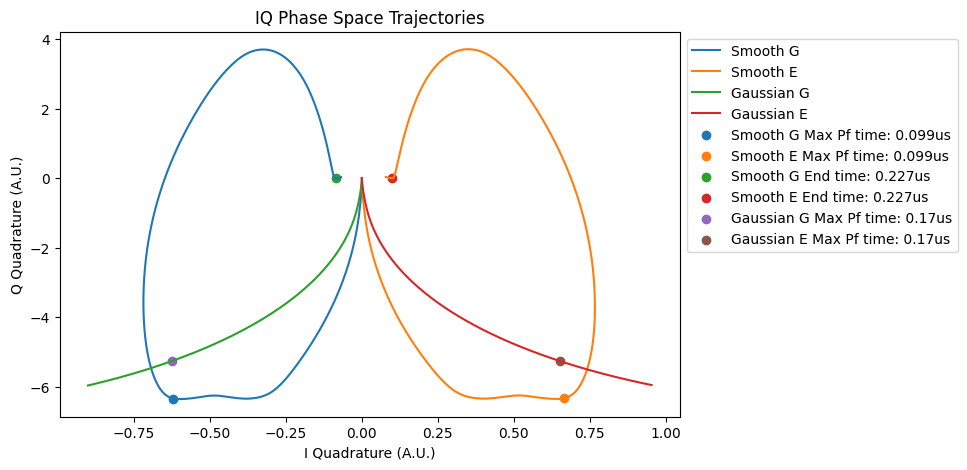

In [36]:
env.rollout_action(-mean_actions_low[-1], photon_log_scale=True)